# Econophysics
## Statistical analysis of an asset
### Eliseu Venites Filho

The asset chosen is the Ether (ETH), the cryptocorrency generated by the Ethereum plataform.

# Data parsing
The data used is provided by the website _coinmarketcap.com_

Dataset size =  958


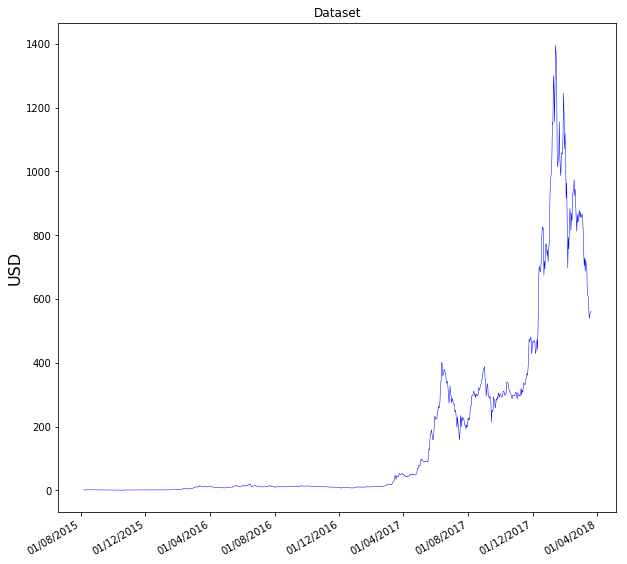

In [1]:
# Date parsing libs
import datetime as dt
import calendar
# Numerical libs
import numpy as np
# Linear regression
from scipy import stats
# Kernel Density Estimation lib
from sklearn.neighbors import KernelDensity
# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as pltdates
%matplotlib inline

# Open data file
data_file = open('eth.dat', 'r')

# Data arrays
price_date = []
open_price = np.array([])
high_price = np.array([])
low_price = np.array([])
close_price = np.array([])
volume = np.array([])
m_cap = np.array([])

# Read data file line by line
for line in data_file:
    if not line.startswith('#'): # Skip comments
        row = line.split()
        # Date parsing 
        month = list(calendar.month_abbr).index(row[0])
        price_date.insert(0, dt.date(int(row[2]), month, int(row[1])))
        # Data parsing
        open_price = np.insert(open_price, 0, float(row[3]), axis=0)
        high_price = np.insert(high_price, 0, float(row[4]), axis=0)
        low_price = np.insert(low_price, 0, float(row[5]), axis=0)
        close_price = np.insert(close_price, 0, float(row[6]), axis=0)
        volume = np.insert(volume, 0, float(row[7]), axis=0)
        m_cap = np.insert(m_cap, 0, float(row[8]), axis=0)

# Dataset size
data_size = close_price.size
print ('Dataset size = ', data_size)

# Plot dataset
plt.figure(figsize=(10,10))
plt.title('Dataset')
plt.ylabel('USD', fontsize=16)
plt.gca().xaxis.set_major_formatter(pltdates.DateFormatter('%d/%m/%Y'))
#plt.gca().xaxis.set_major_locator(pltdates.DayLocator())
plt.plot(price_date, close_price, 'b', linewidth=0.5)
plt.gcf().autofmt_xdate()
plt.show()

# Defining the return
Return on a given date $r_n$ is defined as following:

\begin{align}
r_n &= \frac{x_n - x_{n-1}}{x_{n-1}} \\
    &= \frac{x_n}{x_{n-1}} - 1
\end{align}

where the $x_n$ are the closing prices of the asset.

If we take the logarithm of the return and use the fist order approximation $\ln{y} \approx y-1$ we obtain

\begin{align}
r_n &= \frac{x_n}{x_{n-1}} - 1         \\
    &\approx \ln{\frac{x_n}{x_{n-1}}} = \ln{x_n} - \ln{n_{n-1}}
\end{align}

yielding

$$r_n \approx \ln{x_n} - \ln{n_{n-1}}$$


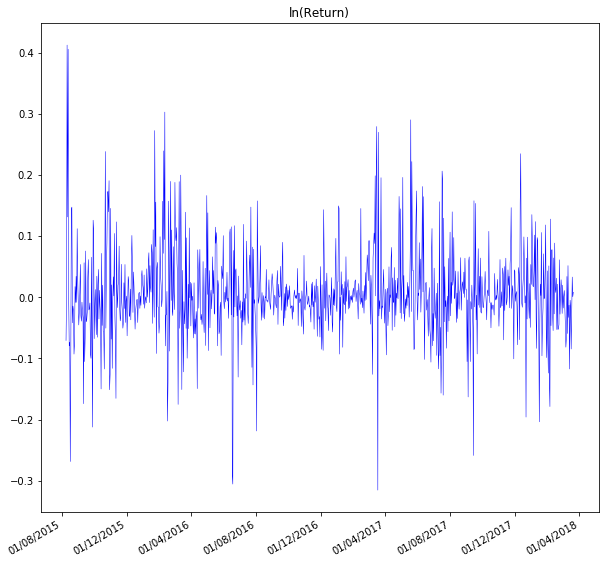

In [2]:
# Define return
r = np.log(close_price) - np.log(np.roll(close_price, 1))
r = np.delete(r, [0,1])
price_date = np.delete(price_date, [0,1])

# Plot return
plt.figure(figsize=(10,10))
plt.title('ln(Return)')
plt.gca().xaxis.set_major_formatter(pltdates.DateFormatter('%d/%m/%Y'))
plt.plot(price_date, r, 'b', linewidth=0.5)
plt.gcf().autofmt_xdate()
plt.show()

# Power pectral density of the random signal

Assuming the value of the return is given by a stationary process, we can calculate its amplitude spectral density which is equal to its truncated Fourier transform.

$$\widetilde{r}(\omega) = \mathscr{F}[t(t)](\omega) =\frac{1}{\sqrt{T}}\int_{[0,T]} dt e^{-i\omega t} r(t)$$

To actually calculate this value using our discrete dataset we will use the Fast Fourier Transform algorithm and a Hanning window.
Why? The Fast Fourier Transform (FFT) is an useful and as the name already said a faster way to calculate the direct Fourier Transform. This is possible,because it use already calculated results or interim results that made earliver. With this idea the transform is faster and it can be used in the modern technology like UMTS or LTE.
The idea of the Hanning window or of a window function in general is to solve a problem that is commom with a analysis of a continuous signal, like what we have. To analyze this, the continuous signal is cutting in diffrent parts, and will be analyze separately, this gives some mistakes. Just in the case that this window includes exactly a real multiple of the period. In the most case that not happend, so the window function tries to restrict the window to a real multiple of the perio and cut a part of the beggining and of the end of the window. For diffrent kinds of datas are diffrent types of window functions and for this one the Hanning window is the best one.

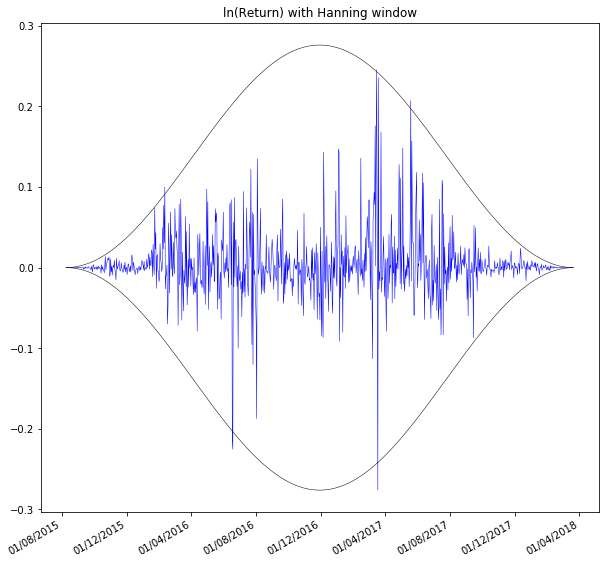

In [3]:
# Apply Hanning window
hann = np.hanning(np.size(r))
r_hann = hann*r
hann = hann*np.max(np.abs(r_hann))
# Plot
plt.figure(figsize=(10,10))

plt.title('ln(Return) with Hanning window')
plt.gca().xaxis.set_major_formatter(pltdates.DateFormatter('%d/%m/%Y'))
plt.gcf().autofmt_xdate()

plt.plot(price_date, r_hann, 'b', linewidth=0.5)
plt.plot(price_date, hann, 'k', linewidth=0.5)
plt.plot(price_date, -hann, 'k', linewidth=0.5)

plt.show()

## PSD calculation

The actual power spectral density is

$$S(\omega) = |\widetilde{r}(\omega)|^2$$

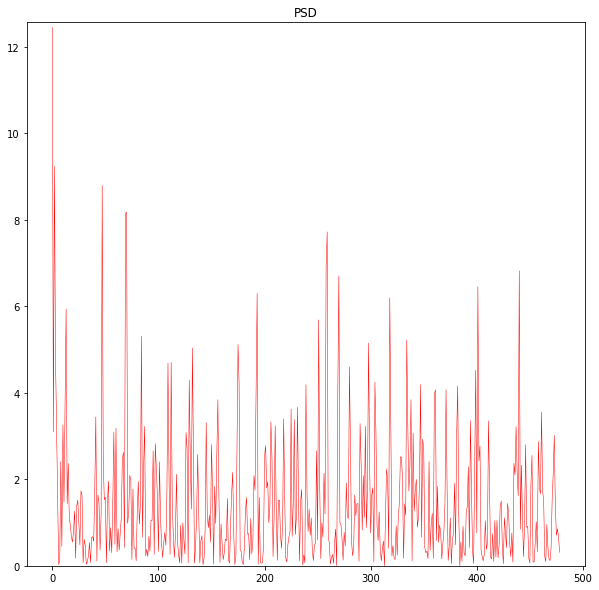

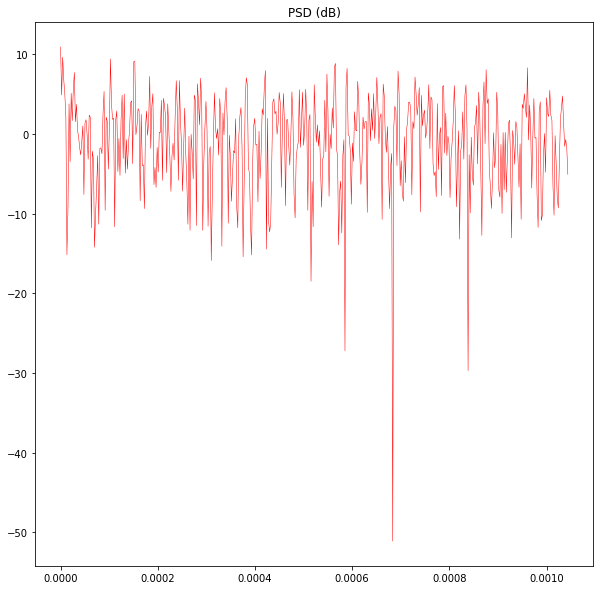

In [4]:
# FFT (with Hanning window)
r_fft = np.fft.fft(r_hann)
S_r = np.real(r_fft * r_fft.conjugate())

# Plot (Power Spectral Density)
plt.figure(figsize=(10,10))
plt.title('PSD')
plt.ylim((0, 1.01*np.max(S_r)))
plt.plot(S_r[:int(data_size/2)], 'r', linewidth=0.5)
plt.show()

# Plot Power Spectral Density
plt.figure(figsize=(10,10))
plt.title('PSD (dB)')
x_plot = np.linspace(0, 1/data_size, int(data_size/2))
y_dB = 10*np.log10(S_r[:int(data_size/2)])
plt.plot(x_plot, y_dB, 'r', linewidth=0.5)
plt.show()

# Autocorrelation

Once we have Power Spectral Density the Autocorrelation function is easily calculated using the Wiener-Khinchin theorem.

The Autocorrelation function is simply the Inverse Fourier Transform of the Power Spectral Density.

$$A(\tau) = \mathscr{F}^{-1}[S(\omega)](\tau)$$

The result is an almost zero autocorrelation for intervals $\tau \neq 0$ which means that the values of the return for at two different times are completely unrelated. This result is predicted by the efficient market hypothesis.

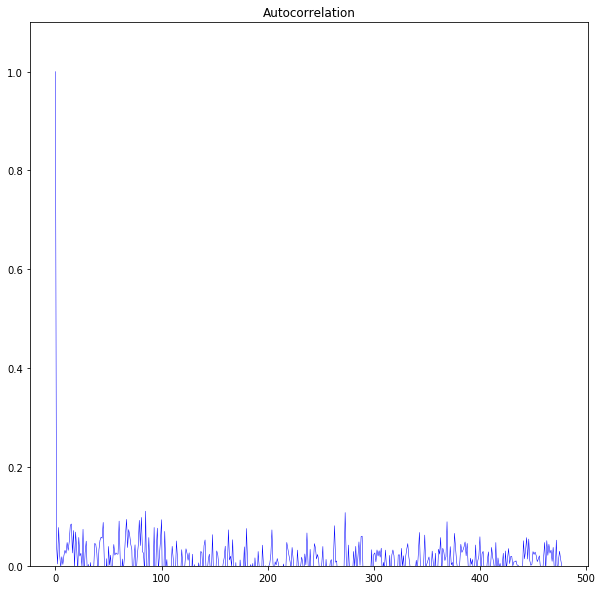

In [5]:
# IFFT (Autocorrelation)
A = np.real(np.fft.ifft(S_r))
A = (1/np.max(A)) * A
# Plot
plt.figure(figsize=(10,10))
plt.title('Autocorrelation')
plt.ylim((0, 1.1*np.max(A)))
plt.plot(A[:int(data_size/2)], 'b', linewidth=0.5)
plt.show()

The same calculation is performed but this time using the square of the returns.
The non-zero nature of the autocorrelation function for intervals $\tau > 0$ represents what Mandelbrot called _volatility clustering_, this implies that although returns are not correlated, as shown above, their variance is weakly but noticeably correlated.

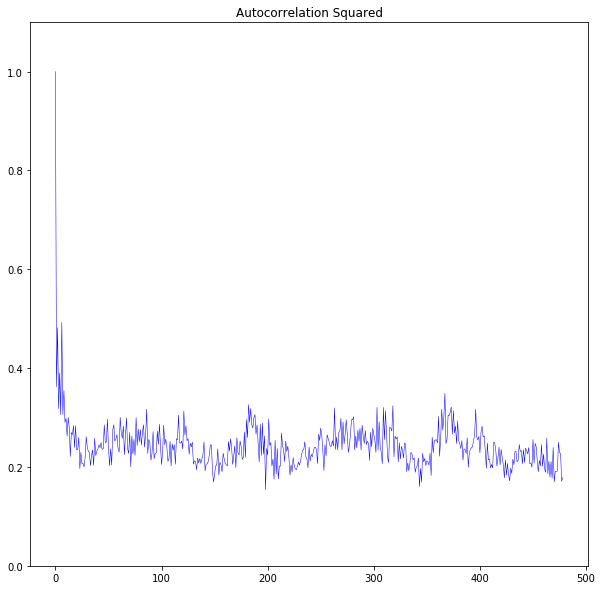

In [6]:
# Volatility Clusters
r_sq = np.square(r)
r_sq_fft = np.real(np.fft.fft(r_sq))
A_sq = np.real(np.fft.ifft(r_sq_fft * np.conj(r_sq_fft)))
A_sq = (1/np.max(A_sq)) * A_sq
# Plot
plt.figure(figsize=(10,10))
plt.title('Autocorrelation Squared')
plt.ylim((0, 1.1*np.max(A_sq)))
plt.plot(A_sq[:int(data_size/2)], 'b', linewidth=0.5)
plt.show()

# Kernel Density Estimation

We are now interested in calculating the probability density function of the return.
Assuming the values of the return $\{r_n\}_{n=1}^N$ are a sample drawn from an unknown density function $f(r)$, we can construct an estimator for this density function using a kernel $K(u)$ in the following way

$$\hat{f}_h (r) = \frac{1}{Nh} \sum_{n=1}^{N} K\left(\frac{r - r_i}{h}\right)$$

The kernel chosen for this calculation is the _Epanechnikov_ kernel

$$K_E(u) = \frac{3}{4}(1 - u^2)$$
$$|u| \leq 1$$

Bandwidth = bw


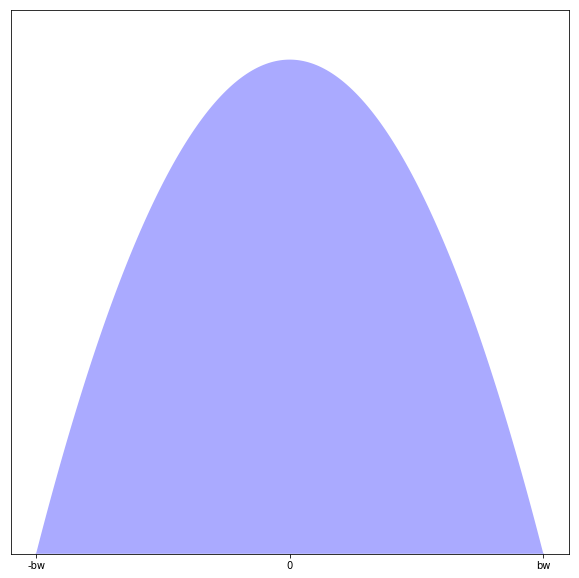

Histogram:
number of bins = 50
Kernel Density Estimation (Epanechnikov)
bandwidth = 0.014556118395784377


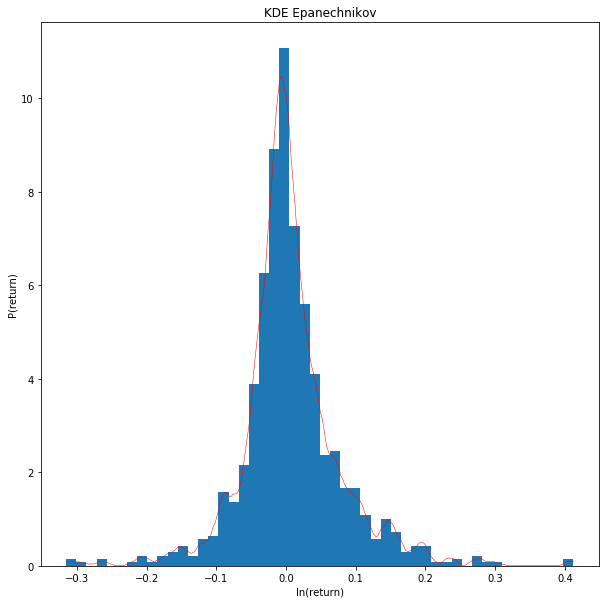

In [7]:
# Plot Epanechnikov kernel
plt.figure(figsize=(10,10))
plt.title('Epanechnikov kernel')
# Axes config
print('Bandwidth = bw')
def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return 'bw'
    elif x == -1:
        return '-bw'
    else:
        return '%ibw' % x
ax = plt.axes(label='Kernel_axes')
ax.axes.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax.axes.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.axes.yaxis.set_major_locator(plt.NullLocator())
# Generate data
x_plot = np.linspace(-2,2,1000)
y_epa = np.exp(KernelDensity(kernel='epanechnikov').fit(np.zeros((1,1))).score_samples(x_plot[:,np.newaxis]))
plt.xlim((-1.1,1.1))
plt.ylim((0, 1.1*np.max(y_epa)))
plt.fill(x_plot, y_epa, fc='#AAAAFF', linewidth=0.5)
plt.show()

# Histogram
print('Histogram:')
nbins = 50
print('number of bins = {}'.format(nbins))
plt.figure(figsize=(10,10))
plt.hist(r, bins=nbins, density=True)

# Kernel Density Estimation
print('Kernel Density Estimation (Epanechnikov)')
x_plot = np.linspace(np.min(r), np.max(r), 1000)
bw = (x_plot[-1] - x_plot[0])/nbins
print('bandwidth = {}'.format(bw))
kde = KernelDensity(kernel='epanechnikov', bandwidth=bw).fit(r[:,np.newaxis])
plt.title('KDE Epanechnikov')
plt.xlabel('ln(return)')
plt.ylabel('P(return)')
Plog = kde.score_samples(x_plot[:,np.newaxis])
plt.plot(x_plot, np.exp(Plog), 'r', linewidth=0.5)
plt.show()

# Pareto Distribution

We will work with the hypothesis that both the positive and negative returns follow a _Pareto distribution_

$$f_P(r;r_0, \alpha) = \frac{\alpha r_0^{\alpha}}{r^{\alpha+1}}$$

## Distribution Fit

Our first strategy is trying to fit a Pareto distribution to the distrbution previously obtained with the _Kernel Density Estimation_.

We notice that $\ln{f_P}$ is a linear function of $\ln{r}$

\begin{align}
\ln{f_P(r;r_0, \alpha)} &= (-\alpha-1)\ln{r} + (\ln{\alpha} + \alpha\ln{r_0})   \\
                          &= A\ln{r} + B
\end{align}

a linear regression will allow us to calculate both parameters

\begin{cases}
\alpha &= -A-1\\
r_0 &= \exp{(\frac{B - \ln{\alpha}}{\alpha})}
\end{cases}

## Likelihood Function and Hill Estimator

The other strategy consists of maximizing the _Likelihood function_ defined by

$$\mathcal{L}(\{r\}_{n=1}^N;\theta) = \prod_{n=1}^{N}f(r_n;\theta)$$

in the case of the Pareto distribution we have

$$\mathcal{L}(\{r\}_{n=1}^N; r_0, \alpha) = \alpha^N r_0^{N\alpha} \prod_{n=1}^{N}r_n^{-(1+\alpha)}$$

The application of the monotonic function $\mathcal{L}\rightarrow\ln{\mathcal{L}}$ transforms the product in a sum and preserves the order, such that the maximum of $\mathcal{L}(\{r\}_{n=1}^N;\theta)$ is attained at the same value of $\theta$ as $\ln{\mathcal{L}(\{r\}_{n=1}^N;\theta)}$

$$\ln{\mathcal{L}(\{r\}_{n=1}^N; r_0, \alpha)} = N\ln{\alpha} + N\alpha\ln{r_0} - (1+\alpha)\sum_{n=1}^{N}\ln{r_n}$$

we solve for the value of $\alpha$ that maximizes the _Likelihood function_

$$\frac{\partial\ln{\mathcal{L}}}{\partial\alpha} = \frac{N}{\alpha_{Hill}} + N\ln{r_0} - \sum_{n=1}^{N}\ln{r_n} = 0$$

$$\implies \alpha_{Hill} = \frac{N}{\sum_{n=1}^{N}\ln{(r_n/r_0)}}$$

The value found for $\alpha$ is known as _Hill Estimator_.


Positive Returns
	Linear Fit:
		y(x) =  -23.17861498256474 x  +  2.319935400362249
		alpha =  22.17861498256474
		r_0 = 0.9654773538444742 (e=0.034522646155525805)
	Hill estimator:
		Hill: alpha =  10.945295516976111
		Relative error = 1.0263148626883387

Negative Returns
	Linear Fit:
		y(x) =  33.46270219412453 x  +  2.855511680909979
		alpha =  32.46270219412453
		r_0 = 0.9809439759128297 (e=0.01905602408717033)
	Hill estimator:
		Hill: alpha =  16.45987004132056
		Relative error = 0.9722332018801334


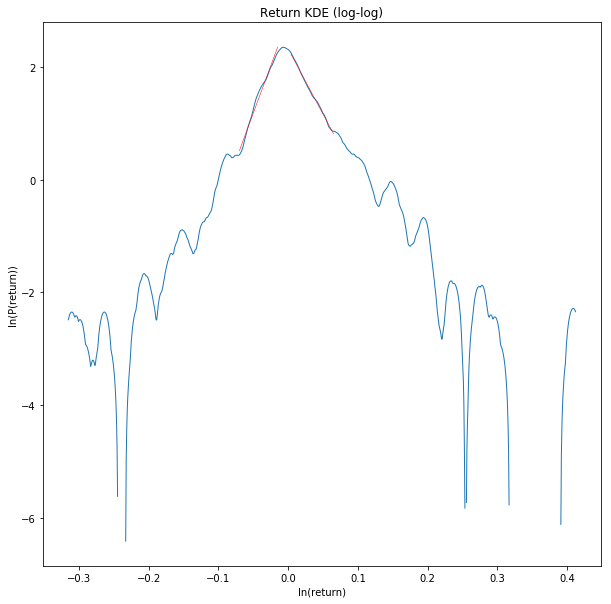

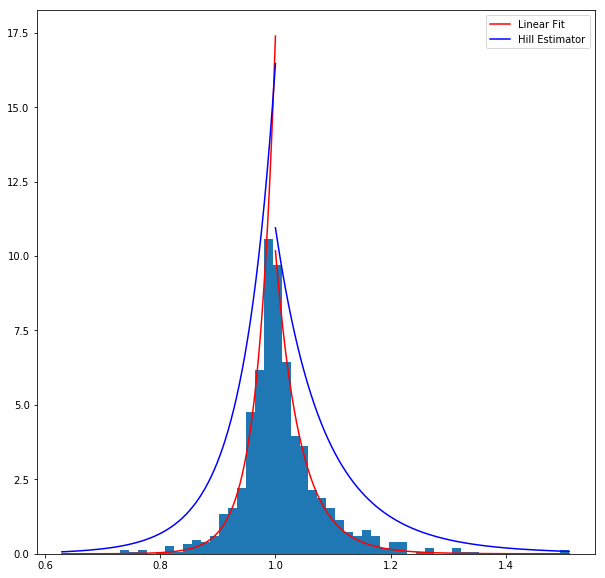

In [8]:
# Plot (log-log) of estimated return distribution
plt.figure(figsize=(10,10))
plt.title('Return KDE (log-log)')
plt.xlabel('ln(return)')
plt.ylabel('ln(P(return))')
plt.plot(x_plot, Plog, linewidth=1.0)

# Linear Fit on log-log plot

# Positive Returns
print('\nPositive Returns')

print('\tLinear Fit:')
# Select linear region
x_fit_p = np.linspace(0.004, 0.065, 1000)

y_fit_p = kde.score_samples(x_fit_p[:,np.newaxis])
a, b, r_val, p_val, std_err = stats.linregress(x_fit_p, y_fit_p)

if b < 0:
    print('\t\ty(x) = ', a, 'x', ' - ', np.abs(b))
else:
    print('\t\ty(x) = ', a, 'x', ' + ', b)

y_fit_p = a*x_fit_p + b

alpha_p = -a-1
x_0_p = np.exp((b-np.log(alpha_p))/alpha_p)
print('\t\talpha = ', alpha_p)
print('\t\tr_0 = {0} (e={1})'.format(x_0_p, np.absolute(1-x_0_p)))

plt.plot(x_fit_p, y_fit_p, 'r', linewidth=0.5)

# Hill Estimator
print('\tHill estimator:')
r_p = r[r > 0.0]
alpha_H_p = np.size(r_p)/np.sum(r_p - np.log(x_0_p))
print('\t\tHill: alpha = ', alpha_H_p)
print('\t\tRelative error = {}'.format(np.absolute(alpha_p-alpha_H_p)/alpha_H_p))

# Negative Returns
print('\nNegative Returns')

print('\tLinear Fit:')
# Select linear region
x_fit_n = np.linspace(-0.07, -0.015, 1000)

y_fit_n = kde.score_samples(x_fit_n[:,np.newaxis])
a, b, r_val, p_val, std_err = stats.linregress(x_fit_n, y_fit_n)

if b < 0:
    print('\t\ty(x) = ', a, 'x', ' - ', np.abs(b))
else:
    print('\t\ty(x) = ', a, 'x', ' + ', b)

y_fit_n = a*x_fit_n + b

alpha_n = a-1
x_0_n = np.exp((b-np.log(alpha_n))/alpha_n)
print('\t\talpha = ', alpha_n)
print('\t\tr_0 = {0} (e={1})'.format(x_0_n, np.absolute(1-x_0_n)))

plt.plot(x_fit_n, y_fit_n, 'r', linewidth=0.5)

# Hill Estimator
print('\tHill estimator:')
r_n = np.absolute(r[r < 0.0])
alpha_H_n = np.size(r_n)/np.sum(r_n - np.log(x_0_n))
print('\t\tHill: alpha = ', alpha_H_n)
print('\t\tRelative error = {}'.format(np.absolute(alpha_n-alpha_H_n)/alpha_H_n))

# Plot everything
plt.show()

# Plot histogram
plt.figure(figsize=(10,10))
plt.hist(np.exp(r), bins=nbins, density=True)

# Positive region
# Linear Fit Plot
x_plot = np.linspace(1, np.max(np.exp(r_p)), 1000)
y_plot = alpha_p * np.power(x_0_p, alpha_p) / np.power(x_plot, 1+alpha_p)
plt.plot(x_plot, y_plot, 'r', label='Linear Fit')
# Hill Estimator Plot
x_plot = np.linspace(1, np.max(np.exp(r_p)), 1000)
y_plot_H = alpha_H_p / np.power(x_plot, 1+alpha_H_p)
plt.plot(x_plot, y_plot_H, 'b', label='Hill Estimator')

# Negative region
# Linear Fit Plot
x_plot = np.linspace(1, np.max(np.exp(r_n)), 1000)
y_plot = alpha_n * np.power(x_0_n, alpha_n)/np.power(x_plot, 1+alpha_n)
plt.plot(2-x_plot, y_plot, 'r')
# Hill Estimator Plot
x_plot = np.linspace(1, np.max(np.exp(r_n)), 1000)
y_plot_H = alpha_H_n / np.power(x_plot, 1+alpha_H_n)
plt.plot(2-x_plot, y_plot_H, 'b')

plt.legend()
plt.show()

According to the plots laid abovev the histogram, the linear fit yields very good results for both regions (positive and negative returns) while the Hill estimator does not.

For the positive region the values found are $\alpha = 22.179$ and $r_0 = 0.965$ which is very close to the expected $r_0 = 1$ (relative error of $e=0.0345$).

The same is the case for the negative region with $\alpha = 32.463$ and $r_0 = 0.981$ ($e=0.019$).

The same process is applied

Analysis of the Absolute Value of Returns

Histogram:
	number of bins = 50
Kernel Density Estimation (Epanechnikov)
	bandwidth = 0.008246745310282749


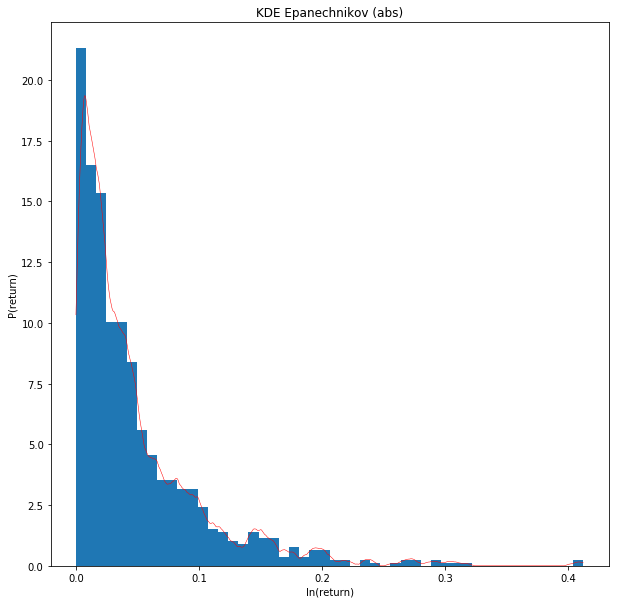

Linear Fit:
	y(x) =  -23.603971823737957 x  +  3.1165971253004483
	alpha =  22.603971823737957
	x_0 = 0.9999323809867176 (e=6.761901328244946e-05)
Hill estimator:
	Hill: alpha =  20.54488601994354
	Relative error = 0.10022376380163904


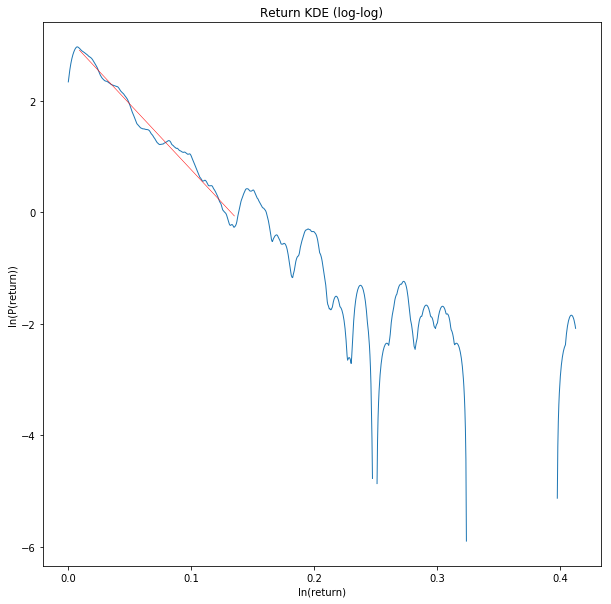

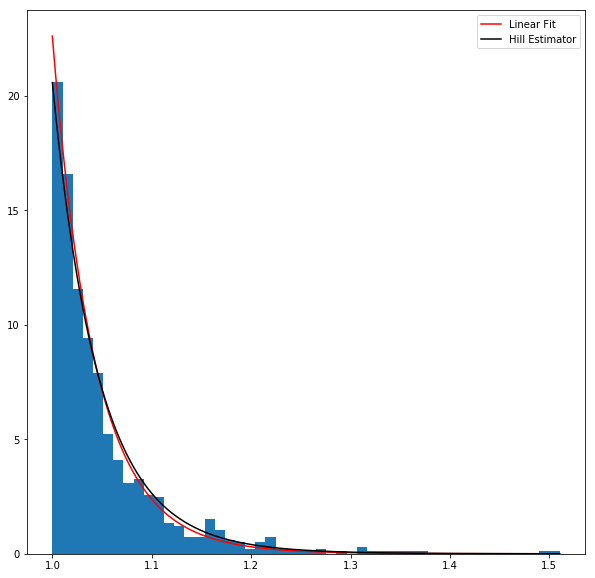

In [9]:
print('Analysis of the Absolute Value of Returns\n')

# Absolute Value of Returns
r_a = np.absolute(r)

# Histogram
print('Histogram:')
nbins = 50
print('\tnumber of bins = {}'.format(nbins))
plt.figure(figsize=(10,10))
plt.hist(r_a, bins=nbins, density=True)

# Kernel Density Estimation
print('Kernel Density Estimation (Epanechnikov)')
x_plot = np.linspace(np.min(r_a), np.max(r_a), 1000)
bw = (x_plot[-1] - x_plot[0])/nbins
print('\tbandwidth = {}'.format(bw))
kde = KernelDensity(kernel='epanechnikov', bandwidth=bw).fit(r_a[:,np.newaxis])
plt.title('KDE Epanechnikov (abs)')
plt.xlabel('ln(return)')
plt.ylabel('P(return)')
Plog = kde.score_samples(x_plot[:,np.newaxis])
plt.plot(x_plot, np.exp(Plog), 'r', linewidth=0.5)
plt.show()

# Pareto Distribution Fit

# Plot (log-log) of estimated return distribution
plt.figure(figsize=(10,10))
plt.title('Return KDE (log-log)')
plt.xlabel('ln(return)')
plt.ylabel('ln(P(return))')
plt.plot(x_plot, Plog, linewidth=1.0)

# Linear Fit on log-log plot

print('Linear Fit:')
# Select linear region
x_fit_a = np.linspace(0.009, 0.135, 1000)

y_fit_a = kde.score_samples(x_fit_a[:,np.newaxis])
a, b, r_val, p_val, std_err = stats.linregress(x_fit_a, y_fit_a)

if b < 0:
    print('\ty(x) = ', a, 'x', ' - ', np.abs(b))
else:
    print('\ty(x) = ', a, 'x', ' + ', b)

y_fit_a = a*x_fit_a + b

alpha_a = -a-1
x_0_a = np.exp((b-np.log(alpha_a))/alpha_a)
print('\talpha = ', alpha_a)
print('\tx_0 = {0} (e={1})'.format(x_0_a, np.absolute(1-x_0_a)))

plt.plot(x_fit_a, y_fit_a, 'r', linewidth=0.5)

# Hill Estimator
print('Hill estimator:')
alpha_H_a = np.size(r_a)/np.sum(r_a - np.log(x_0_a))
print('\tHill: alpha = ', alpha_H_a)
print('\tRelative error = {}'.format(np.absolute(alpha_a-alpha_H_a)/alpha_H_a))

plt.show()

# Plot Pareto curve
plt.figure(figsize=(10,10))
plt.hist(np.exp(r_a), bins=nbins, density=True)
# Linear Fit Plot
x_plot = np.linspace(x_0_a, np.max(np.exp(r_a)), 1000)
y_plot = alpha_a*np.power(x_0_a, alpha_a)/np.power(x_plot, 1+alpha_a)
plt.plot(x_plot, y_plot, 'r', label='Linear Fit')
# Hill Estimator Plot
y_plot_H = alpha_H_a/np.power(x_plot, 1+alpha_H_a)
x_plot = np.linspace(1, np.max(np.exp(r_a)), 1000)
plt.plot(x_plot, y_plot_H, 'k', label='Hill Estimator')

plt.legend()
plt.show()

A much better result and an agreement between the fit and the estimator is obtained when considering the absolute value of the returns.

\begin{cases}
\alpha_{fit} &= 22.604    \\
\alpha_{Hill} &= 20.545 & \mbox{(}e=0.1\mbox{)}
\end{cases}

As for the value of $r_0$, the fit gives a value very close to the expected.

$$r_0 = 0.99993 \quad \mbox{(}e=6.762\times10^{-5}\mbox{)}$$

# Kolmogorow-Smirnow test

The goal now is calculate how well the distributions generated above (using linear fit and Hill Estimator) represent the dataset.

For a dataset $\{r_n\}_{n=1}^{N}$ of $N$ elements, the _Empirical Distribution Function_ is

$$F_N(r) = \frac{1}{N}\sum_{n=1}^{N} I_{[-\infty, r]}(r_i)$$

where $I_{[-\infty, r]}(r_n)$ is the indicator function defined by

\begin{equation}
I_{[-\infty, r]}(r_n) =
\begin{cases}
1, &\mbox{if } r_n \leq r \\
0, &\mbox{otherwise}
\end{cases}
\end{equation}

The Kolmogorov–Smirnov statistic is calculated using the _Cumulative Distribution Function_ that we want to test

$$D_N = \sup_r |F_N(r) - F(r)|$$

for the case of the Pareto distribution $f_P(r)$ this cumulative distribution is

$$F(r) = \int_{-\infty}^{r} dr' f_P(r'; r_0, \alpha)$$

Finally we can reject at level $\alpha$ the _Null Hypothesis_ that the dataset is drawn from the distribution $F(r)$ if

$$\sqrt{n}D_N > K_\alpha$$

The function provided by SciPy returns both the statistic $D_N$ and the probability-value $p$ that the _Null Hypothesis_ is valid.

In [10]:
print('\nLinear Fit:')
print('\t', stats.kstest(np.exp(r_a), 'pareto', args=(alpha_a, 0, 1)))
print('\nHill Estimator:')
print('\t', stats.kstest(np.exp(r_a), 'pareto', args=(alpha_H_a, 0, 1)))


Linear Fit:
	 KstestResult(statistic=0.03430683360469222, pvalue=0.20594617450832908)

Hill Estimator:
	 KstestResult(statistic=0.04596602603377958, pvalue=0.0341057116332244)


The goodness of fit given by _Kolmogorow-Smirnow test_ applied to the Pareto distributions calculated by the linear fit and the _Hill Estimator_ yield the following p-values:

\begin{cases}
p_{fit} &= 20.59\% \\
p_{Hill} &= 3.41\%
\end{cases}

Using a significance level of $5\%$ we cannot reject the _Null Hypothesis_ that the our dataset comes from the distribution $f_P(r, r_0=1, \alpha_{fit})$.

# Markov Chains

## Stochastic matrix

\begin{equation}
P_{ij} = P(i \rightarrow j)
\end{equation}

\begin{equation}
x_n = x_0P^n
\end{equation}

\begin{equation}
P^\infty = \lim_{n \rightarrow \infty} P^n
\end{equation}

P = 


matrix([[0.39787798, 0.17771883, 0.42440318],
        [0.34517766, 0.31472081, 0.34010152],
        [0.41361257, 0.18062827, 0.40575916]])

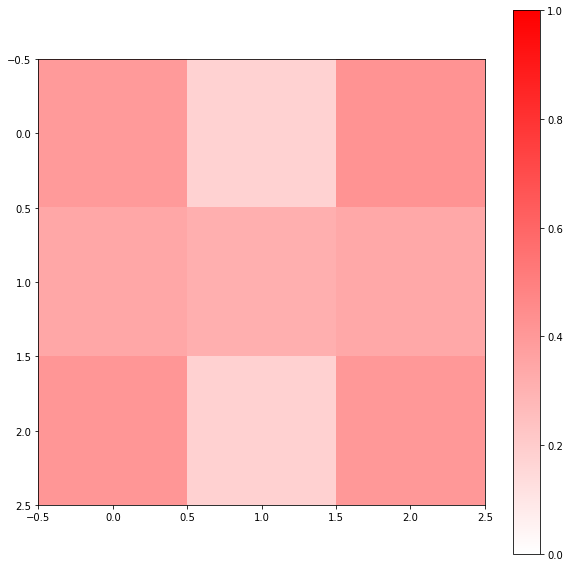

Eigenvalues:


array([ 1.        , -0.01705191,  0.13540987])

Eigenvectors:


matrix([[-0.65797529, -0.70027052,  0.36914342],
        [-0.34682193, -0.01347978, -0.81528547],
        [-0.66841834,  0.7137503 ,  0.44614205]])

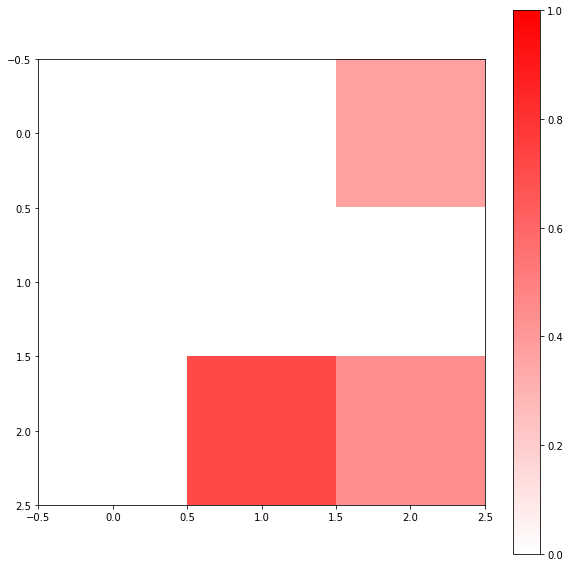

Iterations for P^inf: 19
pi = 


matrix([[0.39324   , 0.20727869, 0.39948131]])

pi P = 


matrix([[0.39324   , 0.20727869, 0.39948131]])

E = 


matrix([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

e = 


matrix([[1., 1., 1.]])

pi = e (I + E -P)^-1


matrix([[0.39324   , 0.20727869, 0.39948131]])

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# Markov stochstic matrix
def markov_3matrix(arr, t):
    
    size = np.size(arr)
    
    M = np.matrix(np.zeros((3,3)))
    
    # Initial state
    d = arr[1] - arr[0]
    if np.abs(d) < t*arr[0]:
        s = 0
    elif d > 0:
        s = 1
    else:
        s = -1

    # Loop
    for i in range(1, size-1):
        d = arr[i+1] - arr[i]
        if np.abs(d) < t*arr[i]:
            sn = 0
        elif d > 0:
            sn = 1
        else:
            sn = -1
        M[s+1, sn+1] += 1
        s = sn

    # Normalize
    M[0] = M[0]/np.sum(M[0])
    M[1] = M[1]/np.sum(M[1])
    M[2] = M[2]/np.sum(M[2])

    return M

# Calculate stochastic matrix of prices
P = markov_3matrix(close_price, 0.01)

print('P = ')
display(P)

# Plot matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
probcmap = colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'red'])
plt.imshow(P, interpolation='nearest', cmap=probcmap, vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Solve eigensystem
a, v = np.linalg.eig(np.matrix.transpose(P))

print('Eigenvalues:')
display(a)
print('Eigenvectors:')
display(v)
# Plot matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(v, interpolation='nearest', cmap=probcmap, vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Calculate P_inf and pi
def stat_lim(M, eps):
    M0 = M
    M1 = M*M0
    it = 1
    while np.linalg.norm(M1-M0) > eps:
        M0 = M1
        M1 = M*M0
        it += 1
    print('Iterations for P^inf:', it)
    return M1

P_inf = stat_lim(P, np.finfo(float).eps)
pi = P_inf[0]

print('pi = ')
display(pi)
print('pi P = ')
display(pi*P)


# E and e
E = np.matrix(np.ones((3,3)))
print('E = ')
display(E)

e = np.matrix(np.ones((1,3)))
print('e = ')
display(e)

pi_ = e*np.linalg.inv(np.eye(3,3) + E -P)
print('pi = e (I + E -P)^-1')
display(pi_)

delta =  22.826822326207115


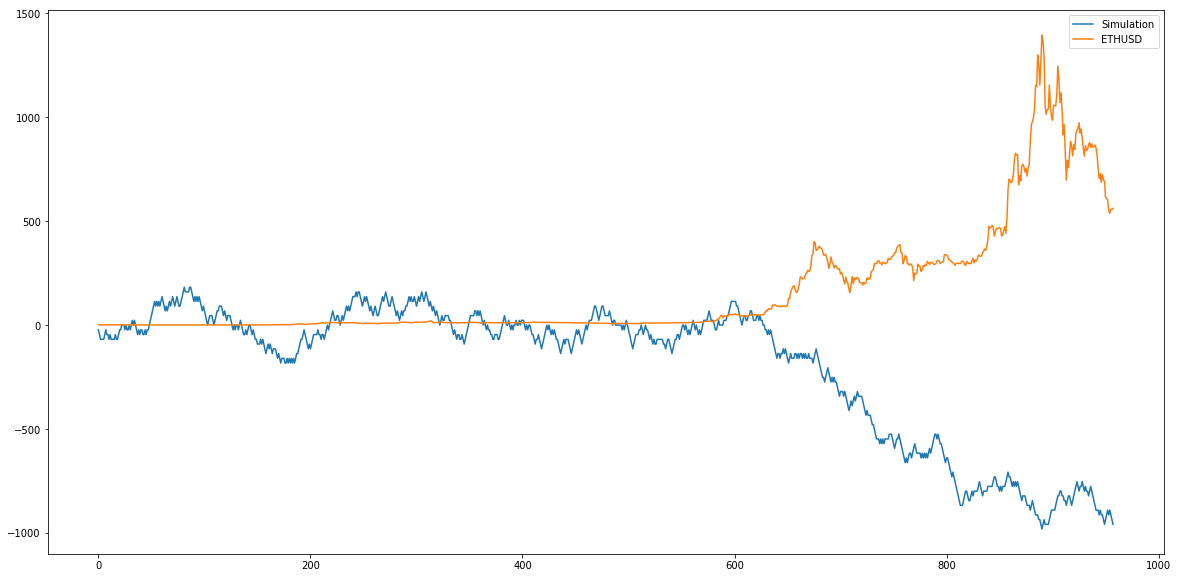

In [121]:
d = close_price - np.roll(close_price, 1)
d = np.delete(d, [0,1])

delta = np.sqrt(np.mean(np.power(d,2)))

print('delta = ', delta)

n_steps = np.size(close_price)

s = 0
x = 0
p = np.array(P)
x_sim = np.array([])
for n in range(n_steps):
    s = np.random.choice([-1,0,1],p=p[s+1])
    x += s*delta
    x_sim = np.append(x_sim, x)

plt.figure(figsize=(20,10))
plt.plot(x_sim, label='Simulation')
plt.plot(close_price, label='ETHUSD')
plt.legend()
plt.show()

P = 


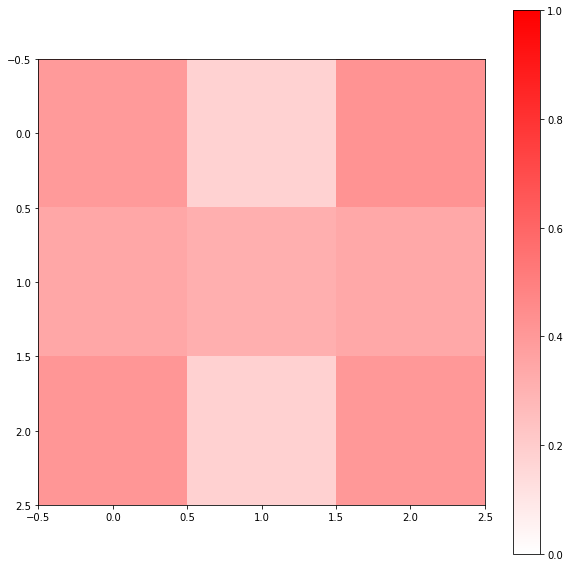

mu = 


matrix([[2.54297629, 5.58874624, 2.45674422],
        [2.7020598 , 4.82442261, 2.69673042],
        [2.50415033, 5.57278373, 2.50324604]])

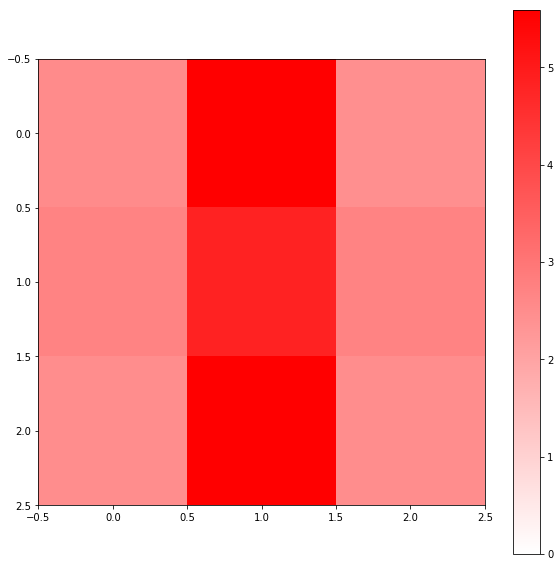

In [12]:
from scipy import sparse

def Mindex(n):
    return(int(n/3), n%3)
def vindex(i, j):
    return 3*i + j

def make_sys(M):
    #S = np.matrix(np.zeros((9,9)))
    sS = sparse.lil_matrix((9,9))
    
    for n in range(9):
        i = Mindex(n)[0]
        j = Mindex(n)[1]
        for k in range(3):
            if k == j:
                continue
            sS[n, vindex(k,j)] = M[i, k]
            
    
    return sparse.eye(9) - sS

sS = make_sys(P)

#print('System matrix:')
#print(sS)

mu = sparse.linalg.spsolve(sS, np.ones((9,1)))
mu = np.matrix(mu.reshape(3,3))

# Plot P
print('P = ')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
probcmap = colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'red'])
plt.imshow(P, interpolation='nearest', cmap=probcmap, vmin=0, vmax=1)
plt.colorbar()
plt.show()

print('mu = ')
display(mu)

# Plot mu
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
probcmap = colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'red'])
plt.imshow(mu, interpolation='nearest', cmap=probcmap, vmin=0)
plt.colorbar()
plt.show()